<a href="https://colab.research.google.com/github/rzninvo/multi_label_text_classification/blob/main/multi_label_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-label text classification

**Author:** [Farrokh Karimi](https://farrokhkarimi.github.io/)  
**Description:** In this notebook, we want to classify the Ronash dataset into 20 category.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import tensorflow as tf

from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

In [2]:
# downloading Data from the Google Drive link
!gdown 1Yq3XTnACkvaIiNlhX09Zth55nOau7jQy

Downloading...
From: https://drive.google.com/uc?id=1Yq3XTnACkvaIiNlhX09Zth55nOau7jQy
To: /content/Ronash_DS_Assignment.csv
100% 1.05M/1.05M [00:00<00:00, 34.9MB/s]


In [3]:
ls

glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip              sample_data/
glove.6B.200d.txt  glove.6B.50d.txt   Ronash_DS_Assignment.csv


In [4]:
# reading the csv file as a dataframe
df = pd.read_csv('Ronash_DS_Assignment.csv')
df

,product_id,title,vendor,tags,category
0,3937721221199,Fidele Super Premium Adult Large Breed Dog Food,Fidele,"['Adult', 'Bangalore', 'Chennai', 'Chicken', '...",Animals & Pet Supplies
1,7353058033889,Foldable Pet Toys Linen Storage,Cap Point,[],Animals & Pet Supplies
2,6594773549129,Bok Dok Diaper,Pets Home,"['Brand_Pet Arabia', 'Category_Pets Home', 'Ca...",Animals & Pet Supplies
3,4802008318014,Tastybone Toy Chicken,TastyBone,[],Animals & Pet Supplies
4,1779705151539,Leather Leash Tab - Short Dog Leash,Mighty Paw,"['Leash', 'Leash Tab', 'Training']",Animals & Pet Supplies
...,...,...,...,...,...
5265,4637089464407,Candylab MOO Milk Van,Candylab,"['3 Years +', 'candylab', 'Discount Products',...",Vehicles & Parts
5266,4996632444987,"Truck - Modern Era Vehicles -- Red, White - S...",Woodland Scenics,"['HO Scale', 'ho-scale-items', 'vehicles', 'wo...",Vehicles & Parts
5267,5528541003927,Car Sticker Flags Decal American Flag Sticker for,Cyan Selene,['Other'],Vehicles & Parts
5268,1395163889730,Lazer Helmets Bayamo Pit Bull - Full Face,OPEN BOX BARGAINS,"['65061090', 'Antiscratch Pinlock Ready Visor'...",Vehicles & Parts


In [5]:
# counting the number of each label
df['category'].value_counts()

Apparel & Accessories        1000
Animals & Pet Supplies        500
Food, Beverages & Tobacco     400
Sporting Goods                400
Luggage & Bags                400
Home & Garden                 400
Health & Beauty               400
Media                         300
Toys & Games                  300
Furniture                     200
Baby & Toddler                200
Arts & Entertainment          200
Electronics                   100
Business & Industrial         100
Office Supplies               100
Vehicles & Parts              100
Hardware                       50
Cameras & Optics               50
Software                       50
Religious & Ceremonial         20
Name: category, dtype: int64

In [6]:
# counting how many indices are duplicated in each column
print(f"There are {sum(df['title'].duplicated())} duplicate title.")
print(f"There are {sum(df['vendor'].duplicated())} duplicate vondor.")
print(f"There are {sum(df['tags'].duplicated())} duplicate tags.")

There are 0 duplicate title.
There are 1256 duplicate vondor.
There are 716 duplicate tags.


In [7]:
# counting the number of Nan samples
df.isnull().values.sum()

3

There are just 3 Nan samples in the dataset so we can ignore them.

In [8]:
# the function for extracting and standardizing the sentences
def text_extraction(dfi):
  # in this function, we concatenate text feature parts of the data as a sentence
  sentence = ' '.join([dfi['title'], str(dfi['vendor']), dfi['tags']])
  # Remove punctuations
  sentence = re.sub('[^a-zA-Z0-9$.]', ' ', sentence)
  # Single character removal
  sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
  # Removing multiple spaces
  sentence = re.sub(r'\s+', ' ', sentence)
  # Changint to lowercase
  sentence = sentence.lower()
  return sentence

# printing 10 sample sentences
for i in range(10):
  print(text_extraction(df.iloc[i]))

fidele super premium adult large breed dog food fidele adult bangalore chennai chicken doberman dog dry foods fidele german shepherd golden retriever great dane highpriority imported labrador less than 1000 less than 2000 less than 500 mastiff orange pet nutrition 
foldable pet toys linen storage cap point 
bok dok diaper pets home brand pet arabia category pets home category small pets supplies type pet home type pet supplies 
tastybone toy chicken tastybone 
leather leash tab short dog leash mighty paw leash leash tab training 
pridebites texas guitar dog toy pride bites brand pridebites toy type plush 
burns sensitive pork potato burns 10 25 25 50 50 75 adult burns coat dog food food delivery jansale18 natural nonsale19 sensitive size 12kg size 2kg size 6kg skin 
bully sticks dog toy adog.co bully sticks dog chew toys dog toys 
kazoo tough giraffe dog toy kazoo brand kazoo june2021 kazoo material plush plush 
orgo dog biscuits fresh milk petku brand orgo category dogs dogs lifestage

In [9]:
# creating the dataset
dataset = pd.DataFrame(columns=['text', 'label'])
for i in range(len(df)):
  dataset = dataset.append({'text':text_extraction(df.iloc[i]), 'label':df.iloc[i]['category']}, ignore_index = True)

# creating integer labels for multiclass training
dataset['label_int'] = pd.Categorical(dataset['label']).codes
dataset

,text,label,label_int
0,fidele super premium adult large breed dog foo...,Animals & Pet Supplies,0
1,foldable pet toys linen storage cap point,Animals & Pet Supplies,0
2,bok dok diaper pets home brand pet arabia cate...,Animals & Pet Supplies,0
3,tastybone toy chicken tastybone,Animals & Pet Supplies,0
4,leather leash tab short dog leash mighty paw l...,Animals & Pet Supplies,0
...,...,...,...
5265,candylab moo milk van candylab 3 years candyla...,Vehicles & Parts,19
5266,truck modern era vehicles red white scale ho w...,Vehicles & Parts,19
5267,car sticker flags decal american flag sticker ...,Vehicles & Parts,19
5268,lazer helmets bayamo pit bull full face open b...,Vehicles & Parts,19


In [10]:
# extracting the names of the labels
labels_names = list(Counter(dataset['label']).keys())
labels_names

['Animals & Pet Supplies',
 'Apparel & Accessories',
 'Arts & Entertainment',
 'Baby & Toddler',
 'Business & Industrial',
 'Cameras & Optics',
 'Electronics',
 'Food, Beverages & Tobacco',
 'Furniture',
 'Hardware',
 'Health & Beauty',
 'Home & Garden',
 'Luggage & Bags',
 'Media',
 'Office Supplies',
 'Religious & Ceremonial',
 'Software',
 'Sporting Goods',
 'Toys & Games',
 'Vehicles & Parts']

In [11]:
# printing each integer label and its corresponding name label
for i, label in enumerate(labels_names):
  print("Label", i, "corresponds to", label)

Label 0 corresponds to Animals & Pet Supplies
Label 1 corresponds to Apparel & Accessories
Label 2 corresponds to Arts & Entertainment
Label 3 corresponds to Baby & Toddler
Label 4 corresponds to Business & Industrial
Label 5 corresponds to Cameras & Optics
Label 6 corresponds to Electronics
Label 7 corresponds to Food, Beverages & Tobacco
Label 8 corresponds to Furniture
Label 9 corresponds to Hardware
Label 10 corresponds to Health & Beauty
Label 11 corresponds to Home & Garden
Label 12 corresponds to Luggage & Bags
Label 13 corresponds to Media
Label 14 corresponds to Office Supplies
Label 15 corresponds to Religious & Ceremonial
Label 16 corresponds to Software
Label 17 corresponds to Sporting Goods
Label 18 corresponds to Toys & Games
Label 19 corresponds to Vehicles & Parts


In [12]:
# splitting dataset to train, validation, and test dataframes
train_df, test_df= train_test_split(dataset, test_size=0.2, random_state=42)
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of samples in training set: {len(train_df)}")
print(f"Number of samples in validation set: {len(val_df)}")
print(f"Number of samples in test set: {len(test_df)}")

# extracting texts and labels from dataframes
train_texts = train_df['text']
train_labels = train_df['label_int']
val_texts = val_df['text']
val_labels = val_df['label_int']
test_texts = test_df['text']
test_labels = test_df['label_int']

Number of samples in training set: 4216
Number of samples in validation set: 527
Number of samples in test set: 527


In [13]:
# creating data generators with batch size 32
batch_size = 32
raw_train_batch = tf.data.Dataset.from_tensor_slices((train_texts, train_labels)).batch(batch_size)
raw_val_batch = tf.data.Dataset.from_tensor_slices((val_texts, val_labels)).batch(batch_size)
raw_test_batch = tf.data.Dataset.from_tensor_slices((test_texts, test_labels)).batch(batch_size)

# printing texts and labels of a batch of raw train
for text, label in raw_train_batch.take(1):
  print('Texts: {}'.format(text))
  print('labels: {}'.format(label))

Texts: [b'housie tambola game by brands with foldable reusable tickets snooplay 13 17 year olds 18 years above 251 500 8 12 year olds age no bar all time favourite below 1000 below 400 below 500 best selling board games creative games gifts customer favourites diwali family friends night family games friends family nights geek gifts for boys gifts for friends gifts for girls gifts for kids gifts for parents googleshopping nerd or geek new new collection outdoor games party accessories party essentials party freak party games party games for grown ups party games for kids premium unique new toys '
 b'foldable waterproof raised dog bed dogiti '
 b'quadrello di bufala cheese cut wrapped by igourmet category cheese cut cheeses milk type buffalo nutrition full set origin italy shipping perishable texture semi soft type stinky and washed rind wholesale cheese collection '
 b'quay vip pink navy to pink lens quay accessories new summer sunglasses '
 b'seachem multitest ammonia seachem '
 b'sma

In [14]:
# counting how many words are there in the whole texts of the dataset
num_of_words = 0
for i in dataset['text']: num_of_words += len(i.split())

print(num_of_words)

112572


There are about 112000 words in the texts.



In [15]:
# counting max sequence length and how many non-repetitive words are there in the whole texts of the dataset
l = []
max_seq_length = 0
for i in dataset['text']:
  length = len(i.split())
  if length > max_seq_length: max_seq_length = length
  for j in i.split():
    if j not in l: l.append(j)

print(max_seq_length)
print(len(l))

309
18933


Maximum sequence length is 309 and There are about 19000 non-repetitive words in the whole dataset texts. So we set max word features to 10000 and sequence length to 350.

In [16]:
# setting the text vectorization layer with 20000 words and 350 sequence length
max_features = 19000
sequence_length = 320

vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# fitting the state of the preprocessing layer to the train set. This will cause the model to build an index of strings to integers.
vectorize_layer.adapt(train_texts)

# defining the vectorize text function
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

# retrieving a sample from a batch of texts and labels from the train set
text_batch, label_batch = next(iter(raw_train_batch))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", first_label)
print("Vectorized text", vectorize_text(first_review, first_label))

Review tf.Tensor(b'housie tambola game by brands with foldable reusable tickets snooplay 13 17 year olds 18 years above 251 500 8 12 year olds age no bar all time favourite below 1000 below 400 below 500 best selling board games creative games gifts customer favourites diwali family friends night family games friends family nights geek gifts for boys gifts for friends gifts for girls gifts for kids gifts for parents googleshopping nerd or geek new new collection outdoor games party accessories party essentials party freak party games party games for grown ups party games for kids premium unique new toys ', shape=(), dtype=string)
Label tf.Tensor(18, shape=(), dtype=int8)
Vectorized text (<tf.Tensor: shape=(1, 320), dtype=int64, numpy=
array([[12501,  9229,   192,    23,   343,    51,  1546,  2392,  9089,
         9635,   740,  1609,   275,  2882,   372,    69,   959, 15878,
          134,   109,    89,   275,  2882,    35,    55,   381,    16,
          480,  7346,   783,   181,   783,

In [17]:
# getting corresponding word of each integer 
print("1401 ---> ",vectorize_layer.get_vocabulary()[1401])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1401 --->  heel
 313 --->  is
Vocabulary size: 16230


In [18]:
# creating train, val, and test vectorized dataset and prefetching them
train_ds = raw_train_batch.map(vectorize_text)
val_ds = raw_val_batch.map(vectorize_text)
test_ds = raw_test_batch.map(vectorize_text)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-02-24 22:33:56--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-02-24 22:33:56--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-02-24 22:33:57--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

In [20]:
import os
path_to_glove_file = os.path.join(
    "glove.6B.100d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [21]:
vocab = vectorize_layer.get_vocabulary()
vocab_size = len(vocab)
word_index = dict(zip(vocab, range(vocab_size)))
num_tokens = vocab_size + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))
print(embedding_matrix.shape)

Converted 11914 words (4316 misses)
(16232, 100)


In [32]:
# model configuration
embedding_dim = 100
num_of_labels = 20

model_new = tf.keras.Sequential([
  layers.Embedding(vocab_size + 2, embedding_dim),
  layers.Conv1D(64, 5, activation="relu"),
  layers.MaxPooling1D(5),
  layers.Conv1D(128, 5, activation="relu"),
  layers.GlobalAveragePooling1D(),
  layers.Dense(128, activation="relu"),
  layers.Dropout(0.5),
  layers.Dense(num_of_labels)])

model_new.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 100)         1623200   
                                                                 
 conv1d_8 (Conv1D)           (None, None, 64)          32064     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, None, 128)         41088     
                                                                 
 global_average_pooling1d_4   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_7 (Dense)             (None, 128)              

In [33]:
# model compilation
model_new.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [62]:
from tensorflow.keras import regularizers

# model configuration
embedding_dim = 100
num_of_labels = 20

model = tf.keras.Sequential([
  layers.Embedding(vocab_size + 1, embedding_dim),
  layers.Dropout(0.4),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(num_of_labels)])

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, None, 100)         1623100   
                                                                 
 dropout_18 (Dropout)        (None, None, 100)         0         
                                                                 
 global_average_pooling1d_13  (None, 100)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_19 (Dropout)        (None, 100)               0         
                                                                 
 dense_16 (Dense)            (None, 20)                2020      
                                                                 
Total params: 1,625,120
Trainable params: 1,625,120
Non-trainable params: 0
___________________________________________

In [63]:
# model compilation
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [64]:
# training the model
epochs = 500

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5,
                                            verbose=1)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=[callback])

Epoch 1/500
132/132 [==============================] - 7s 49ms/step - loss: 2.8195 - accuracy: 0.1848 - val_loss: 2.6905 - val_accuracy: 0.1803
Epoch 2/500
132/132 [==============================] - 5s 39ms/step - loss: 2.6781 - accuracy: 0.1881 - val_loss: 2.6622 - val_accuracy: 0.1803
Epoch 3/500
132/132 [==============================] - 6s 43ms/step - loss: 2.6615 - accuracy: 0.1881 - val_loss: 2.6498 - val_accuracy: 0.1803
Epoch 4/500
132/132 [==============================] - 5s 39ms/step - loss: 2.6483 - accuracy: 0.1881 - val_loss: 2.6378 - val_accuracy: 0.1803
Epoch 5/500
132/132 [==============================] - 6s 46ms/step - loss: 2.6337 - accuracy: 0.1886 - val_loss: 2.6230 - val_accuracy: 0.1822
Epoch 6/500
132/132 [==============================] - 6s 48ms/step - loss: 2.6142 - accuracy: 0.1886 - val_loss: 2.6055 - val_accuracy: 0.1822
Epoch 7/500
132/132 [==============================] - 5s 38ms/step - loss: 2.5902 - accuracy: 0.1912 - val_loss: 2.5840 - val_accuracy:

In [65]:
# printing loss and accuracy of the model on the test set
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

17/17 [==============================] - 0s 4ms/step - loss: 0.7240 - accuracy: 0.8121
Loss:  0.7239654660224915
Accuracy:  0.8121442198753357


In [23]:
# extracting the history of training and its keys
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [24]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

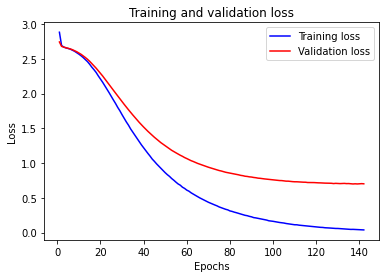

In [25]:
# ploting of loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

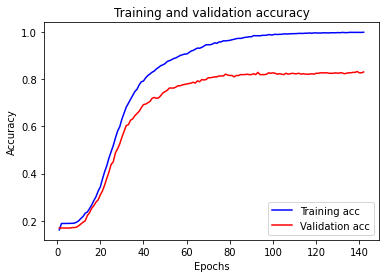

In [26]:
# plotting of accuracy
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [27]:
# creating the probability model for testing
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

# predicting test samples
predictions = probability_model.predict(raw_test_batch.map(vectorize_text))

17/17 [==============================] - 0s 4ms/step


In [28]:
# showing the first test sample result label
np.argmax(predictions[0])

0

In [29]:
# showing the true label of the first test sample
test_df.iloc[0]

text         kazoo tough giraffe dog toy kazoo brand kazoo ...
label                                   Animals & Pet Supplies
label_int                                                    0
Name: 8, dtype: object

**Author:** https://farrokhkarimi.github.io/